In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")
#plt.style.use([u'fivethirtyeight',])
import patsy

from joblib import load, dump
from IPython.display import display, HTML

import model_functions as mf

MF reloaded 1


In [2]:
MODEL_VERSION = "v4"
MODEL_SUFFIX_FA = "%s.first_author" % MODEL_VERSION
MODEL_SUFFIX_LA = "%s.last_author" % MODEL_VERSION
GENDERS = ["-", "F", "M"]
GENDERS = ["UNKNOWN", "FEMALE", "MALE"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

In [3]:
results_full_fa = load("results_all_model/%s/results_all_model_intercept.%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_FA))
results_full_la = load("results_all_model/%s/results_all_model_intercept.%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_LA))

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file 'results_all_model/v4/results_all_model_intercept.v4.first_author.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file 'results_all_model/v4/results_all_model_intercept.v4.last_author.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


In [4]:
TOP_FEATURES_FA = map(lambda x: x[0][0], results_full_fa)
TOP_FEATURES_LA = map(lambda x: x[0][0], results_full_la)
pd.DataFrame({"First": TOP_FEATURES_FA, "Last": TOP_FEATURES_LA})

,First,Last
0,Intercept,Intercept
1,SinkCites,YearSpan
2,AuthorAge,AuthorAge
3,PubType,PubType
4,YearSpan,Journal
5,Journal,SinkCites
6,SourceCites,SourceCites
7,Affiliation,Affiliation
8,VolumeNovelty,VolumeNovelty
9,Language,SourceAuthors


In [5]:
formula_y = "is_self_cite"
formula_items = {
	"AuthorAge": ["I(auth_prev_papers == 0)", "I(auth_prev_papers == 1)",
		"np.log10(auth_prev_papers + 1)", "I(np.log10(auth_prev_papers + 1)**2)"],
	"Gender": ["C(gender, levels=GENDERS)"],
	"Affiliation": ["C(source_country, levels=TOP_15_COUNTRIES)"],
	"Ethnicity": ["mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"],
	"SourceCites": ["I(source_ncites == 1)", "np.log10(source_ncites)",
		"I(np.log10(source_ncites)**2)", "I(np.log10(source_ncites)**3)"],
	"SourceAuthors": ["I(source_n_authors > 20)", "np.log10(np.clip(source_n_authors, 0, 20))",
		"I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"],
	"MeshCounts": ["np.log10(source_n_mesh_ex + 1)", "I(source_n_mesh_ex == 0)",
		"np.log10(sink_n_mesh_ex + 1)", "I(sink_n_mesh_ex == 0)"],
	"YearSpan": ["I(year_span < 0)", "I(year_span == 0)",
		"mf.score_log_1(year_span)", "I(mf.score_log_1(year_span)**2)"],
	"SinkCites": ["I(sink_prev_ncites == 0)", "np.log10(sink_prev_ncites + 1)",
		"I(np.log10(sink_prev_ncites + 1)**2)"],
	"Journal": ["I(jj_sim == 0)", "np.log10(jj_sim + 1)",
		"I(np.log10(jj_sim + 1)**2)", "journal_same"],
	"Language": ["source_is_eng", "sink_is_eng", ],
	"PubType": ["source_is_journal", "source_is_review", "source_is_case_rep", "source_is_let_ed_com",
           "sink_is_journal", "sink_is_review", "sink_is_case_rep", "sink_is_let_ed_com"],
	"VolumeNovelty": ["np.log10(np.nan_to_num(source_V_novelty) + 1)",
			"np.log10(np.nan_to_num(sink_V_novelty) + 1)", "I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"]
}

In [6]:
feature_dict = { 
	"Intercept": [u'Intercept',],
	"Gender": [
		u'C(gender, levels=GENDERS)[T.F]',
		u'C(gender, levels=GENDERS)[T.M]',
		],
	"Affiliation": [
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]',
		u'C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]',
	],
	"Ethnicity": [
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12]',
		u'mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13]',
	],
	"AuthorAge": [
		u'I(auth_prev_papers == 0)[T.True]',
		u'I(auth_prev_papers == 1)[T.True]',        
		u'np.log10(auth_prev_papers + 1)',
		u'I(np.log10(auth_prev_papers + 1) ** 2)',
	],
	"SourceCites": [
		u'I(source_ncites == 1)[T.True]',
		u'np.log10(source_ncites)',
		u'I(np.log10(source_ncites) ** 2)',
        u'I(np.log10(source_ncites) ** 3)',
	],
	"SourceAuthors": [
		u'I(source_n_authors > 20)[T.True]',
		u'np.log10(np.clip(source_n_authors, 0, 20))',
		u'I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)',
	],
	"MeshCounts": [
		u'I(source_n_mesh_ex == 0)[T.True]',
		u'I(sink_n_mesh_ex == 0)[T.True]',
		u'np.log10(source_n_mesh_ex + 1)',
		u'np.log10(sink_n_mesh_ex + 1)',
	],
	"Journal": [
		u'journal_same[T.True]',
		u'I(jj_sim == 0)[T.True]',
		u'np.log10(jj_sim + 1)',
		u'I(np.log10(jj_sim + 1) ** 2)',
	],
	"YearSpan": [
		u'I(year_span < 0)[T.True]',
		u'I(year_span == 0)[T.True]',
		u'mf.score_log_1(year_span)',
		u'I(mf.score_log_1(year_span) ** 2)',
	],
	"SinkCites": [
		u'I(sink_prev_ncites == 0)[T.True]',
		u'np.log10(sink_prev_ncites + 1)',
		u'I(np.log10(sink_prev_ncites + 1) ** 2)',       
	],
	"PubType": [
		u'source_is_journal[T.True]',
		u'source_is_review[T.True]',
		u'source_is_case_rep[T.True]',
		u'source_is_let_ed_com[T.True]',
		u'sink_is_journal[T.True]',
		u'sink_is_review[T.True]',
		u'sink_is_case_rep[T.True]',
		u'sink_is_let_ed_com[T.True]',
	],
	"Language": [
		u'source_is_eng[T.True]',
		u'sink_is_eng[T.True]',
	],
	"VolumeNovelty": [
		u'np.log10(np.nan_to_num(source_V_novelty) + 1)',
		u'np.log10(np.nan_to_num(sink_V_novelty) + 1)',
		u'I(np.log10(np.nan_to_num(sink_V_novelty) + 1) ** 2)'
	]
}


feature_short_codes={
    "AuthorAge": "PC",
    "Gender": "G",
    "Affiliation": "CA",
    "Ethnicity": "E",
    "SourceCites": "NR",
    "SourceAuthors": "NA",
    "MeshCounts": "MC",
    "YearSpan": "YS",
    "SinkCites": "CC",
    "Journal": "J",
    "Language": "L",
    "PubType": "P",
    "VolumeNovelty": "N",
    "Intercept": "O"
}



feature_xlabels={
    "AuthorAge": "age (pub count)",
    "Gender": "gender",
    "Affiliation": "country",
    "Ethnicity": "ethnicity",
    "SourceCites": "reference counts",
    "SourceAuthors": "collaboration size",
    "MeshCounts": "MeSH count",
    "YearSpan": "time lag",
    "SinkCites": "ref. citation count",
    "Journal": "journal",
    "Language": "language",
    "PubType": "publication type",
    "VolumeNovelty": "novelty",
    "Intercept": "intercept"
}

In [7]:
results_full_fa[-1][0][1][1].tables[1].columns

Index([u'Coef.', u'Std.Err.', u'z', u'P>|z|', u'[0.025', u'0.975]'], dtype='object')

In [8]:
def extract_coeffs(summary, feature, feature_dict,
                   select_cols=(u'Coef.', u'Std.Err.', u'z', u'P>|z|', u'[0.025', u'0.975]'),
                  filter_string=""):
    model_df = summary.tables[1]
    items = [k for k in feature_dict[feature] if filter_string in k]
    return model_df.ix[items, select_cols]

In [9]:
extract_coeffs(results_full_fa[-1][0][1][1], feature="AuthorAge", feature_dict=feature_dict)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
I(auth_prev_papers == 0)[T.True],-1.420658,0.009226,-153.981066,0.000000e+00,-1.438741,-1.402575
I(auth_prev_papers == 1)[T.True],-0.235650,0.005250,-44.883493,0.000000e+00,-0.245940,-0.225360
np.log10(auth_prev_papers + 1),1.610435,0.007362,218.749711,0.000000e+00,1.596006,1.624865
I(np.log10(auth_prev_papers + 1) ** 2),-0.090616,0.002470,-36.689077,1.090705e-294,-0.095457,-0.085775


In [10]:
extract_coeffs(results_full_fa[-1][0][1][1], feature="AuthorAge", feature_dict=feature_dict, filter_string="np")

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
np.log10(auth_prev_papers + 1),1.610435,0.007362,218.749711,0.000000e+00,1.596006,1.624865
I(np.log10(auth_prev_papers + 1) ** 2),-0.090616,0.002470,-36.689077,1.090705e-294,-0.095457,-0.085775


In [11]:
def gen_simulation_data(formula, x, weights, baseline_index=0, return_odds_ratio=False):
    X = patsy.dmatrix(formula, data=x, return_type="dataframe")
    X.drop('Intercept', axis=1, inplace=True)
    W = weights["Coef."].values
    y = np.dot(W, X.values.T)
    W_err_l = weights["[0.025"].values
    W_err_u = weights["0.975]"].values
    y_err = (np.dot(W_err_l, X.values.T), np.dot(W_err_u, X.values.T))
    if return_odds_ratio:
        y_baseline = y[baseline_index]
        y_err_baseline = (y_err[0][baseline_index], y_err[1][baseline_index])
        y = y - y_baseline
        y_err = (y_err[0] - y_err_baseline[0], y_err[1] - y_err_baseline[1])
    #print y.shape, y_err[0].shape, y_err[1].shape
    return x.values.flatten(), y, y_err

In [12]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def create_model_plot(ax, summary, feature, feature_dict,
                      x_col, x_range, label="First", color="r", alpha=0.2,
                      plot_odds=False,
                      filter_string = "", baseline_index=0, return_odds_ratio=False, **kwargs):
    W = extract_coeffs(summary, feature=feature, feature_dict=feature_dict, filter_string=filter_string)
    items = [k for k in formula_items[feature] if filter_string in k]
    x, y, y_err = gen_simulation_data("+".join(items), pd.DataFrame({x_col: x_range}), W,
                                     baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    if plot_odds:
        y = np.exp(y)
        y_err = (np.exp(y_err[0]), np.exp(y_err[1]))
    if feature in ["YearSpan", "Journal"]:
        ax.plot(x[:1],y[:1],#yerr=(y[:1]-y_err[0][:1], y_err[1][:1]),
                    marker="o",
                    color=color, **kwargs)
        ax.fill_between(x[:1],y_err[0][:1], y_err[1][:1],
                    color=color, alpha=alpha, **kwargs)
        x, y, y_err = x[1:], y[1:], (y_err[0][1:], y_err[1][1:])
    ax.plot(x,y, color=color, label=label, **kwargs)
    ax.fill_between(x, y_err[0], y_err[1], color=color, alpha=alpha, **kwargs)
    #print y_err[0].min(), y_err[0].max(), y_err[1].min(), y_err[1].max(), 
    return ax, (y_err[1].min(), y_err[0].max())
    #return ax, (y.min(), y.max())

(w.r.t. $x = 0$)
(0.20000000000000001, 1.0)
(w.r.t. $x = 1$)
(w.r.t. $x = 0.0$)
(w.r.t. $x = 5$)
(w.r.t. $x = 1$)
(0.20000000000000001, 1.0)
(w.r.t. $x = 1$)
(0.60000000000000009, 1.0)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(0.80000000000000004, 1.0)


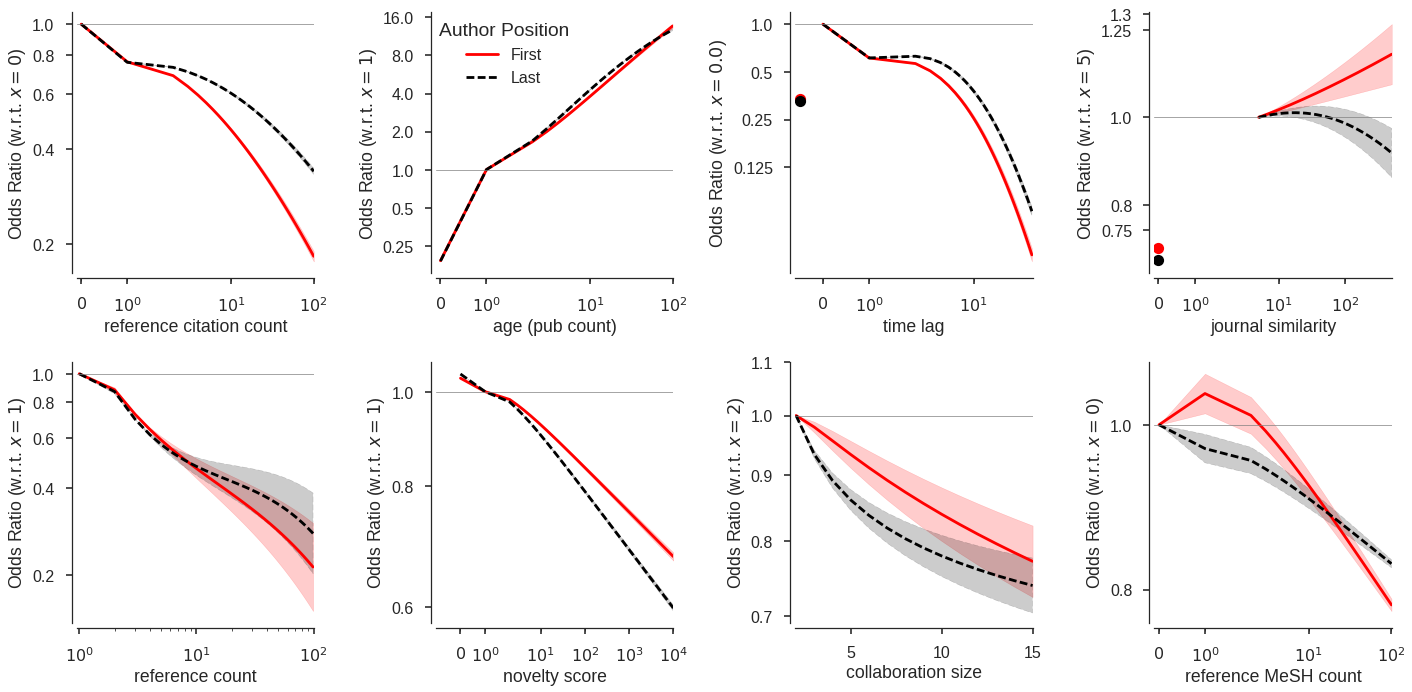

In [13]:
xcols = ["SinkCites", "AuthorAge", "YearSpan", "Journal",  
         "SourceCites", "VolumeNovelty", "SourceAuthors", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "age (pub count)",
                  np.power(2.,range(-2,5))),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "collaboration size",
                     np.arange(0.7,1.1,0.1)),
    "SinkCites": ("sink_prev_ncites", np.arange(0,101), "symlog", [-0.1, 101], None, "reference citation count", None),
    "YearSpan": ("year_span", np.array([-0.5] + range(51)), "symlog", [-0.6,51], None, "time lag",
                 np.power(2.,range(-3,1))),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "novelty score", None),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "reference MeSH count", None),
    "Journal": ("jj_sim", np.array([0] + range(5,500)), "symlog", [-0.1, 501], None, "journal similarity", [0.75, 0.8, 1.0, 1.25, 1.3]),
    "SourceCites": ("source_ncites", np.arange(1,100), "log", [0.95, 101], None, "reference count", None),
}


fig, ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
plot_odds=False
baseline_index = 0
baseline_y= 1 if plot_odds else 0
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl, yticks = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge", "VolumeNovelty", "Journal"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, res in enumerate((results_full_fa, results_full_la)):
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=plot_odds,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=baseline_y, linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    if not plot_odds:
        ylm = np.exp(ax[i].get_ylim())
        if yticks is None:
            spacing=0.2
            ticksarray = np.arange(0.2,1.6,0.2)
            ylm = find_nearest(ticksarray, ylm[0]), find_nearest(ticksarray, ylm[1])
            print ylm
            yticks = np.log(np.arange(ylm[0], ylm[1]+0.2, spacing))
        else:
            yticks = np.log(yticks)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticks)
        #ax[i].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: "%.1f" % np.exp(x)))
        ax[i].yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: np.exp(x)))
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.35,0.95), ncol=1, title="Author Position",
                fancybox=True, frameon=False)

plt.savefig("Opportunity_Visibility_coeffs.%s.first_last.OR_%s.pdf" % (MODEL_VERSION, plot_odds), 
            bbox_inches="tight", bbox_extra_artists=[lgd])

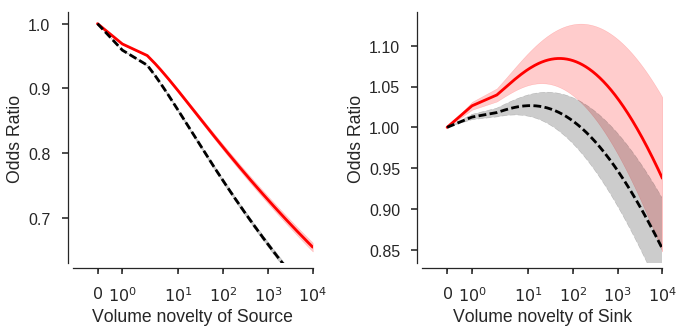

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio = True

feature = "VolumeNovelty"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_V_novelty",
                                              np.arange(0,10000), "symlog", [-1,10001], None, "Volume novelty of %s")
for i, (x_col, xlbl_f) in enumerate(zip(["source_V_novelty", "sink_V_novelty"],
                                     ["Source", "Sink"])):
    for j, res in enumerate((results_full_fa, results_full_la)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

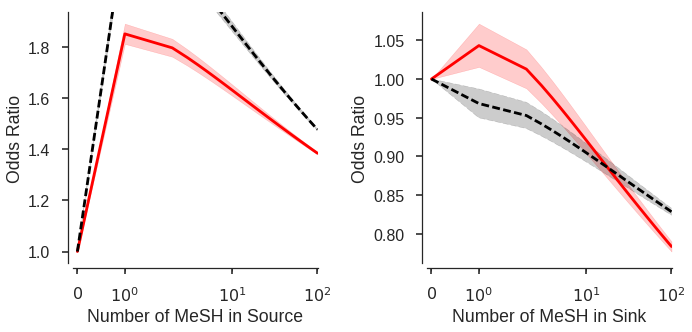

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio = True

feature = "MeshCounts"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_n_mesh_ex",
                                              np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in %s")
for i, (x_col, xlbl_f) in enumerate(zip(["source_n_mesh_ex", "sink_n_mesh_ex"],
                                     ["Source", "Sink"])):
    for j, res in enumerate((results_full_fa, results_full_la)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

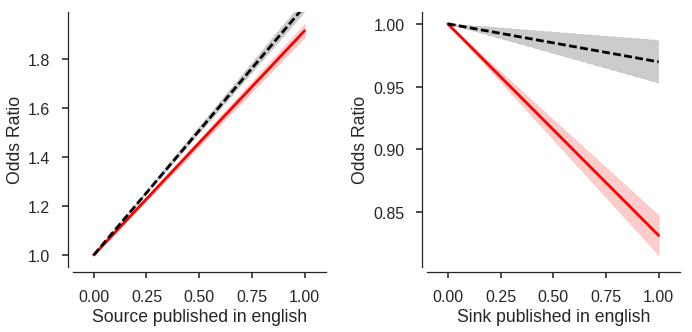

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5), squeeze=False)
ax = ax.flatten()
i = 0
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio=True

feature = "Language"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_is_eng",
                                              np.array([False, True]), "linear", [-0.1, 1.1], None, "%s published in english")
for i, (x_col, xlbl_f) in enumerate(zip(["source_is_eng", "sink_is_eng"],
                                     ["Source", "Sink"])):
    for j, res in enumerate((results_full_fa, results_full_la)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

source_is_journal ('Source', 'Journal article')
sink_is_journal ('Sink', 'Journal article')
source_is_review ('Source', 'Review')
sink_is_review ('Sink', 'Review')
source_is_case_rep ('Source', 'Case report')
sink_is_case_rep ('Sink', 'Case report')
source_is_let_ed_com ('Source', 'Letter, editorial or comment')
sink_is_let_ed_com ('Sink', 'Letter, editorial or comment')


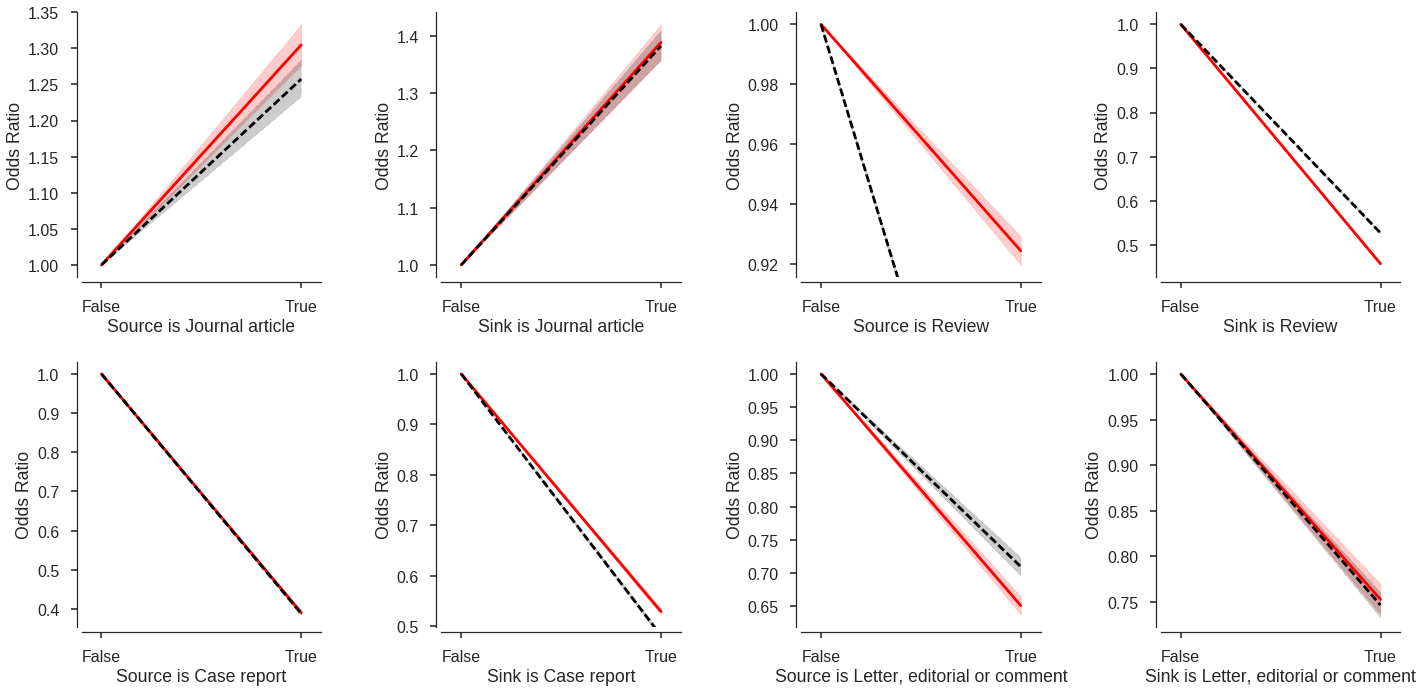

In [17]:
fig, ax = plt.subplots(2,4, figsize=(20,10), squeeze=False)
ax = ax.flatten()
i = 0
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio=True

feature = "PubType"
x_col, x_range, xscale, xlims, ylims, xlbl = ("source_is_eng",
                                              np.array([False, True]), "linear", [-0.1, 1.1], None, "%s is %s")
for i, (x_col, xlbl_f) in enumerate(zip(
        [
            ("%s_is_%s" % (k2, k1)) for k1 in ("journal", "review", "case_rep", "let_ed_com")
            for k2 in ("source", "sink")
        ], [
            (k2, k1) for k1 in ("Journal article", "Review", "Case report", "Letter, editorial or comment")
            for k2 in ("Source", "Sink")
        ]
    )):
    print x_col, xlbl_f
    for j, res in enumerate((results_full_fa, results_full_la)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
        ax[i].set_xlabel(xlbl % xlbl_f)
        ax[i].set_xscale(xscale)
        ax[i].set_xticks([0,1])
        ax[i].set_xticklabels(["False", "True"])
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ylims)
        ax[i].set_ylabel(ylbl)

sns.despine(offset=5)
fig.tight_layout()

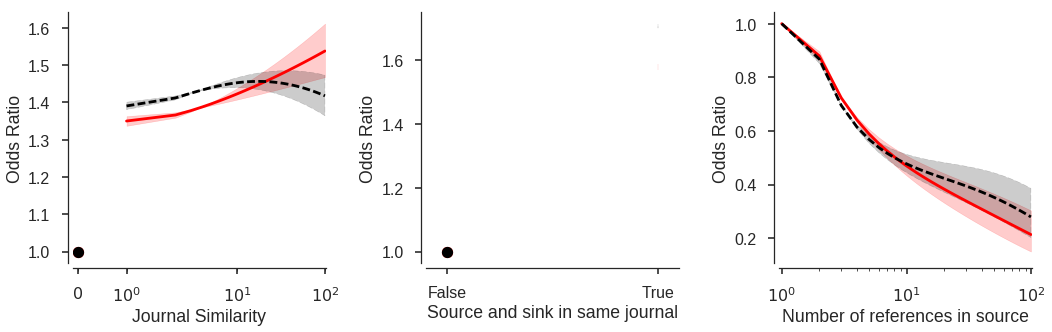

In [18]:
xcols = ["Journal", "Journal_same", "SourceCites"]
plot_params_dict = {
    "Journal": ("jj_sim", np.arange(0,100), "symlog", [-0.1, 101], None, "Journal Similarity"),
    "Journal_same": ("journal_same", np.array([False, True]), "linear", [-0.1, 1.1], None, "Source and sink in same journal"),
    "SourceCites": ("source_ncites", np.arange(1,100), "log", [0.95, 101], None, "Number of references in source"),
}

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax = ax.flatten()
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio"
return_odds_ratio=True

for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl = plot_params_dict[feature]
    if feature == "Journal_same":
        feature = "Journal"
    for j, res in enumerate((results_full_fa, results_full_la)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col, return_odds_ratio=return_odds_ratio)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    if x_col == "journal_same":
        ax[i].set_xticks([0,1])
        ax[i].set_xticklabels(["False", "True"])
    ax[i].set_ylim(ylims)
    ax[i].set_ylabel(ylbl)
    
sns.despine(offset=5)
fig.tight_layout()

## Create model odds ratio plots for categorical variables

In [19]:
extract_coeffs(results_full_fa[-1][0][1][1], feature="Gender", feature_dict=feature_dict)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
"C(gender, levels=GENDERS)[T.F]",-0.028522,0.003335,-8.553271,1.196485e-17,-0.035058,-0.021986
"C(gender, levels=GENDERS)[T.M]",-0.038700,0.003074,-12.589183,2.421665e-36,-0.044725,-0.032675


In [20]:
def create_model_plot_cat(ax, summary, feature, feature_dict,
                      label="First", marker="o", color="r", alpha=0.2,
                      plot_odds=False,
                      filter_string = "", offset=0, reverse=True, **kwargs):    
    W = extract_coeffs(summary, feature=feature, feature_dict=feature_dict, filter_string=filter_string)
    #display(W)
    x = W["Coef."].values
    x_err = (W["[0.025"].values, W["0.975]"].values)
    if reverse:
        x = x[::-1]
        x_err = (x_err[0][::-1], x_err[1][::-1])
    #display(pd.DataFrame({"x": x, "x_err[0]": x_err[0], "x_err[1]": x_err[1]}))
    y = np.arange(x.shape[0]) + offset
    if plot_odds:
        x = np.exp(x)
        x_err = (np.exp(x_err[0]), np.exp(x_err[1]))
    (_, caps, _) = ax.errorbar(x, y, xerr=(x - x_err[0], x_err[1] - x),
                               marker=marker, color=color, linestyle="None",
                               label=label, **kwargs)
    for cap in caps:
        cap.set_color(color)
        cap.set_markeredgewidth(1)
    return ax

In [21]:
def plot_categoricals_from_model(ax, feature, feature_cats, results, 
                                 #results_full_fa, results_full_la,
                                 plot_odds=True,
                                reverse=True, offset=0, xlbl="Odds Ratio w.r.t. %s", filter_string = "",
                                 indiv_models=None, xticks=None,**kwargs):
    baseline_x = 1 if plot_odds else 0
    for j, res in enumerate(results):
        if res is None:
            res = indiv_models[feature][1]
        else:
            res = res[-1][0][1][1]
        create_model_plot_cat(ax, res, feature, feature_dict, plot_odds=plot_odds, 
                              offset=offset, reverse=reverse, filter_string=filter_string,
                              elinewidth=1, **{k:v[j] for k,v in kwargs.iteritems()})
    ax.set_xlim(None)
    ax.set_ylim([-1, len(feature_cats)])
    plt.locator_params(nbins=4)
    ax.set_yticks(np.arange(len(feature_cats[1:])))
    ax.set_yticklabels(feature_cats[1:][::-1])
    ax.set_xlabel(xlbl % feature_cats[0])
    if not plot_odds:
        xlm = np.exp(ax.get_xlim())
        if xticks is None:
            ticksarray = np.arange(0.2,2.0,0.2)
            spacing=0.2
            xlm = find_nearest(ticksarray, xlm[0]), find_nearest(ticksarray, xlm[1])
            xticks = np.log(np.arange(xlm[0], xlm[1]+0.2, spacing))
        else:
            xticks = np.log(xticks)
        print feature, xlm
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        #strfmt = "%.1f" if np.log10(spacing) > -1 else "%.2f"
        #ax.xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: strfmt % np.exp(x)))
        ax.xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: np.exp(x)))
    ax.axvline(x=baseline_x, linestyle="-", linewidth=1, color="0.5", alpha=0.7, lw=1)
    ax.set_title(feature, fontweight="bold")
    return ax

Affiliation (0.60000000000000009, 1.4000000000000001)
Ethnicity (0.80000000000000004, 1.2)
Gender [ 0.95260942  1.03624076]
Language (0.80000000000000004, 1.8)
PubType (0.40000000000000002, 1.4000000000000001)
PubType (0.40000000000000002, 1.6000000000000001)


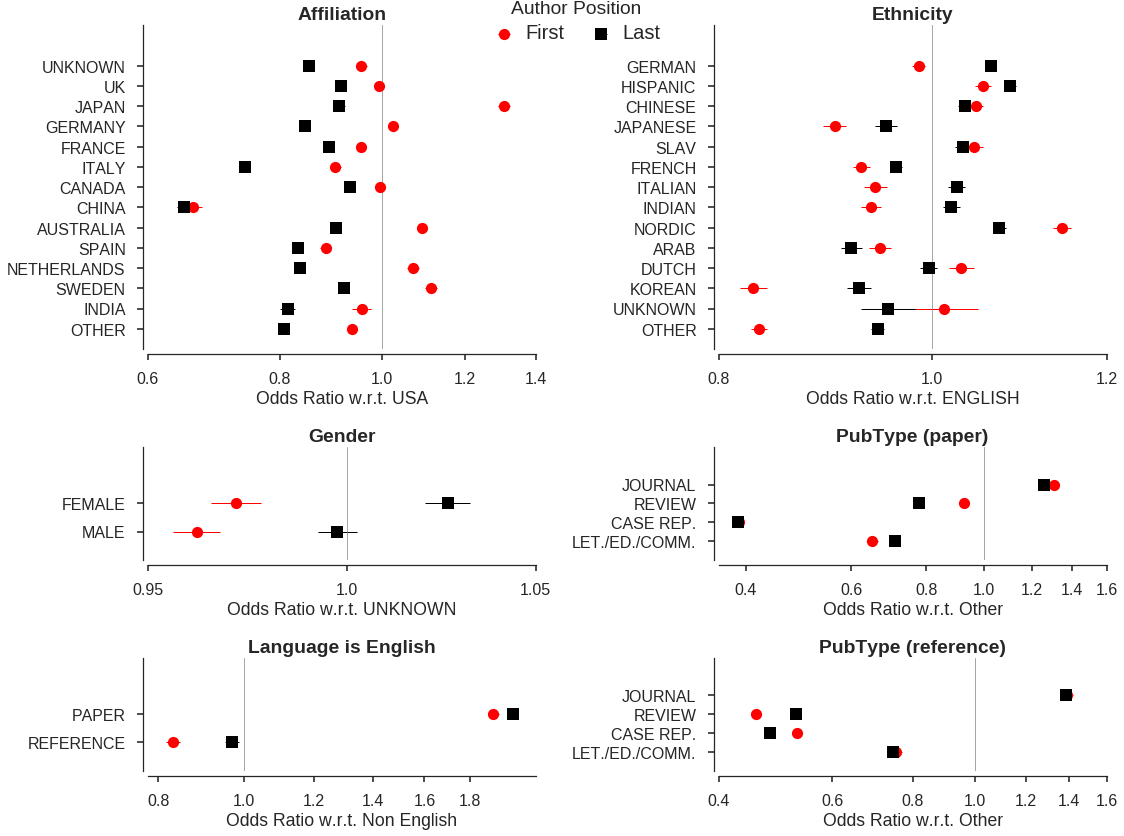

In [22]:
fig = plt.figure(figsize=(16,12))
plot_odds = False
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
colors = ["r", "k"]
labels = ["First", "Last"]
markers = ["o", "s"]

results = (results_full_fa, results_full_la)
feature="Affiliation"
feature_cats = TOP_15_COUNTRIES
ax = plt.subplot2grid((4,2), (0,0), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((4,2), (0,1), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((4,2), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                            xticks=np.arange(0.95,1.09,0.05))

feature="Language"
feature_cats = ["Non English", "PAPER", "REFERENCE"]
ax = plt.subplot2grid((4,2), (3,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="source_"
ax = plt.subplot2grid((4,2), (2,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "paper"), fontweight="bold")

filter_string="sink_"
ax = plt.subplot2grid((4,2), (3,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "reference"), fontweight="bold")

sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,0.98), ncol=2, title="Author Position",
                fancybox=True, frameon=False, prop={"size": 12})

plt.setp(lgd.get_texts(), fontsize=20)

plt.savefig("Culture_PubType_coeffs.%s.first_last.OR_%s.pdf" % (MODEL_VERSION, plot_odds),
           bbox_inches="tight", bbox_extra_artists=[lgd])

## Gender stage plots

In [23]:
def plot_gender_change(ax,results,top_features, colors, markers, title="First Author", yticks=None, plot_odds=True):
    plot_data = pd.DataFrame()
    stages = [feature_xlabels["Gender"]]
    for i, res in enumerate(results[1:]):
        stages.append("%s" % feature_xlabels[top_features[i+1]])
        found = False
        for k, (m, s) in res:
            if k == "Gender":
                plot_data["Stage %s" % i] = s.tables[1].ix[s.tables[1].index.str.startswith("C(gender"), "Coef."]
                found = True
        if not found:
            k, (m,s) = res[0]        
            plot_data["Stage %s" % i] = s.tables[1].ix[s.tables[1].index.str.startswith("C(gender"), "Coef."]

    for i, (idx, l) in enumerate(zip(plot_data.index, GENDERS[1:])):
        if plot_odds:
            x = np.exp(plot_data.ix[idx].values)
            baseline_y = 1.
        else:
            x = plot_data.ix[idx].values
            baseline_y = 0.
        ax.plot(x, label=l, color=colors[i],
                marker=markers[i], ms=10,
                linestyle=":", lw=1)
    #plt.locator_params(nbins=5)
    ax.set_xticks(range(plot_data.shape[1]))
    #ax.set_yticklabels(stages[:-1][::-1], ha="right", family="monospace")
    ax.set_xticklabels(stages[:-1], ha="right", family="monospace", rotation=30)
    ax.set_xlabel("Forward selection step")
    ax.axhline(y=baseline_y, linestyle="--", lw=0.5, color="black")
    ax.set_ylabel("Odds Ratio\nw.r.t. %s" % GENDERS[0])
    #ax.set_yscale("log", basey=np.exp(1))
    if yticks is not None:
        yticks = np.log(yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
        ax.yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, pos: np.exp(x)))
    ax.set_title(title, fontweight="bold")
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.margins(x=0.1, y=0.1)
    return ax

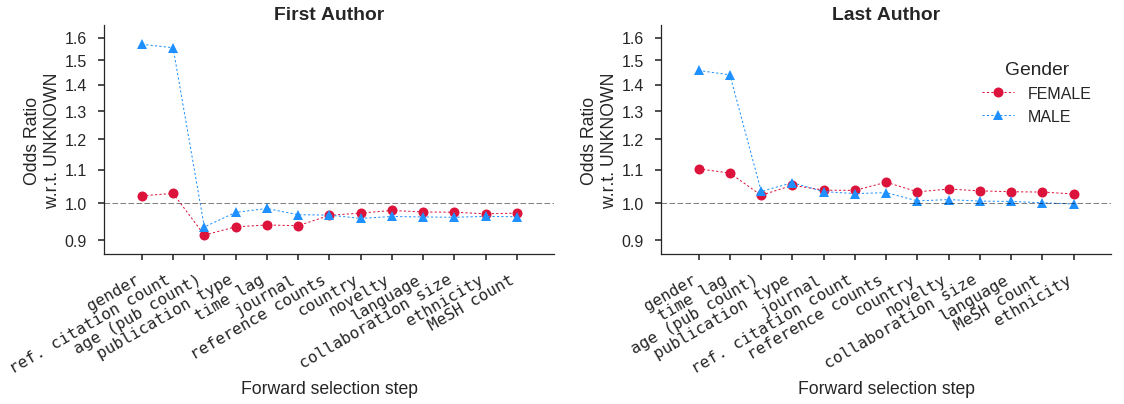

In [24]:
fig = plt.figure(figsize=(16,6))

ax = plt.subplot2grid((1,2), (0,0))
title = "First Author"
markers = ["o", "^"]
colors = ["crimson", "dodgerblue"]
plot_odds = False
plot_gender_change(ax,results_full_fa, TOP_FEATURES_FA, colors, markers, title=title, plot_odds=plot_odds,
                   yticks=[0.5, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])


## Last author
title = "Last Author"
ax = plt.subplot2grid((1,2), (0,1), sharey=ax)
plot_gender_change(ax,results_full_la, TOP_FEATURES_LA, colors, markers, title=title, plot_odds=plot_odds,
                   yticks=[0.5, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])


fig.tight_layout()
lgd = fig.legend(*ax.get_legend_handles_labels(), loc="upper center", 
                 bbox_to_anchor=(0.9,0.85), ncol=1,
                 frameon=False, fancybox=False, title = "Gender", #prop={"size": 12},
                 borderpad=1)

fig.tight_layout()
plt.savefig("Gender_coeffs.%s.first_last.pdf" % (MODEL_VERSION), bbox_inches="tight", bbox_extra_artists=[lgd])

## Filtered Models

### Version 1

In [25]:
version = 1
results_full_fa_f = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_FA, version))
results_full_la_f = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_LA, version))

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.first_author.filtered_1.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.last_author.filtered_1.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  app.launch_new_instance()


(w.r.t. $x = 1$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)


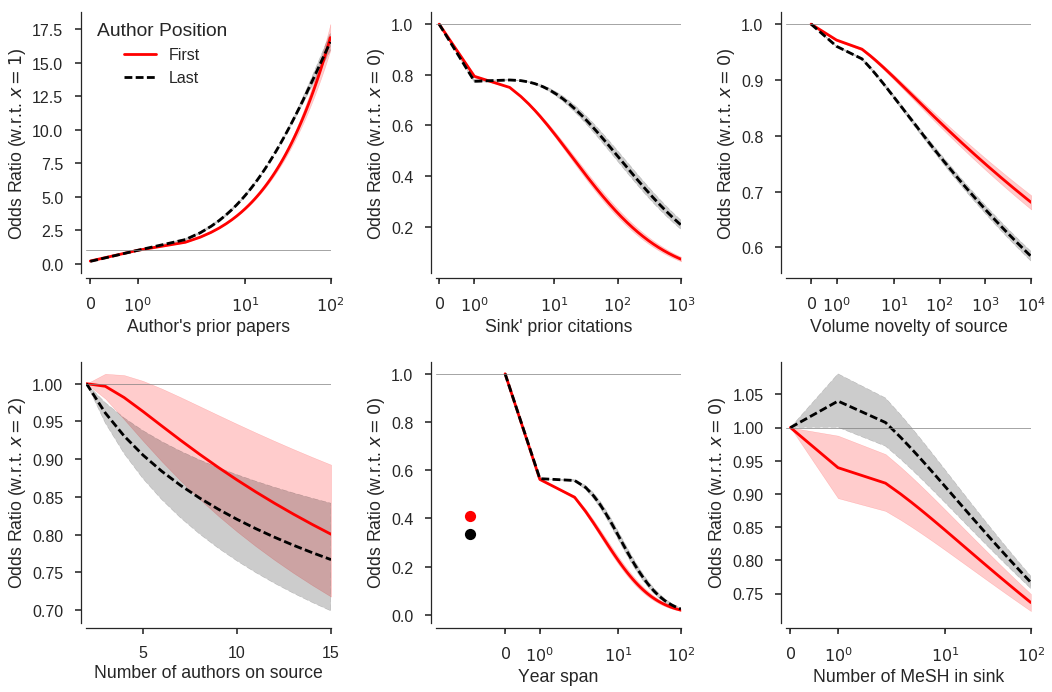

In [26]:
xcols = ["AuthorAge", "SinkCites", "VolumeNovelty",
         "SourceAuthors", "YearSpan", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "Author's prior papers"),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "Number of authors on source"),
    "SinkCites": ("sink_prev_ncites", np.arange(0,1001), "symlog", [-0.1, 1001], None, "Sink' prior citations"),
    "YearSpan": ("year_span", np.arange(-1,101), "symlog", [-2,101], None, "Year span"),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "Volume novelty of source"),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in sink")
}

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
baseline_index = 0
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, res in enumerate((results_full_fa_f, results_full_la_f)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=1., linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.15,0.95), ncol=1, title="Author Position",
                fancybox=True, frameon=False)

plt.savefig("Opportunity_Visibility_coeffs.%s.first_last.filtered_%s.OR_%s.pdf" % (MODEL_VERSION, return_odds_ratio, version), 
            bbox_inches="tight", bbox_extra_artists=[lgd])

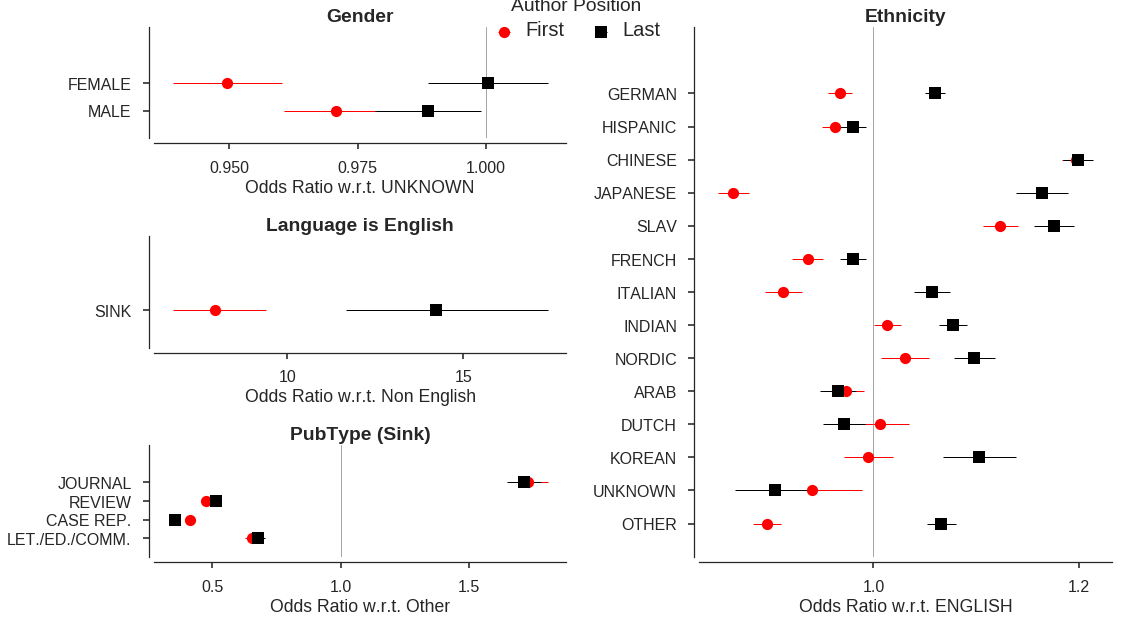

In [27]:
fig = plt.figure(figsize=(16,9))
plot_odds = True
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
colors = ["r", "k"]
labels = ["First", "Last"]
markers = ["o", "s"]


results = (results_full_fa_f, results_full_la_f)

feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((3,2), (0,1), rowspan=3)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((3,2), (0,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""

feature="Language"
feature_cats = ["Non English", "SINK"]
ax = plt.subplot2grid((3,2), (1,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="sink_"
ax = plt.subplot2grid((3,2), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Sink"), fontweight="bold")


sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,0.98), ncol=2, title="Author Position",
                fancybox=True, frameon=False, prop={"size": 12})

plt.setp(lgd.get_texts(), fontsize=20)

plt.savefig("Culture_PubType_coeffs.%s.first_last.filtered_%s.OR_%s.pdf" % (MODEL_VERSION, plot_odds, version),
           bbox_inches="tight", bbox_extra_artists=[lgd])

### Version 2

In [28]:
version = 2
results_full_fa_f = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_FA, version))
results_full_la_f = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_LA, version))

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.first_author.filtered_2.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.last_author.filtered_2.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  app.launch_new_instance()


(w.r.t. $x = 1$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)


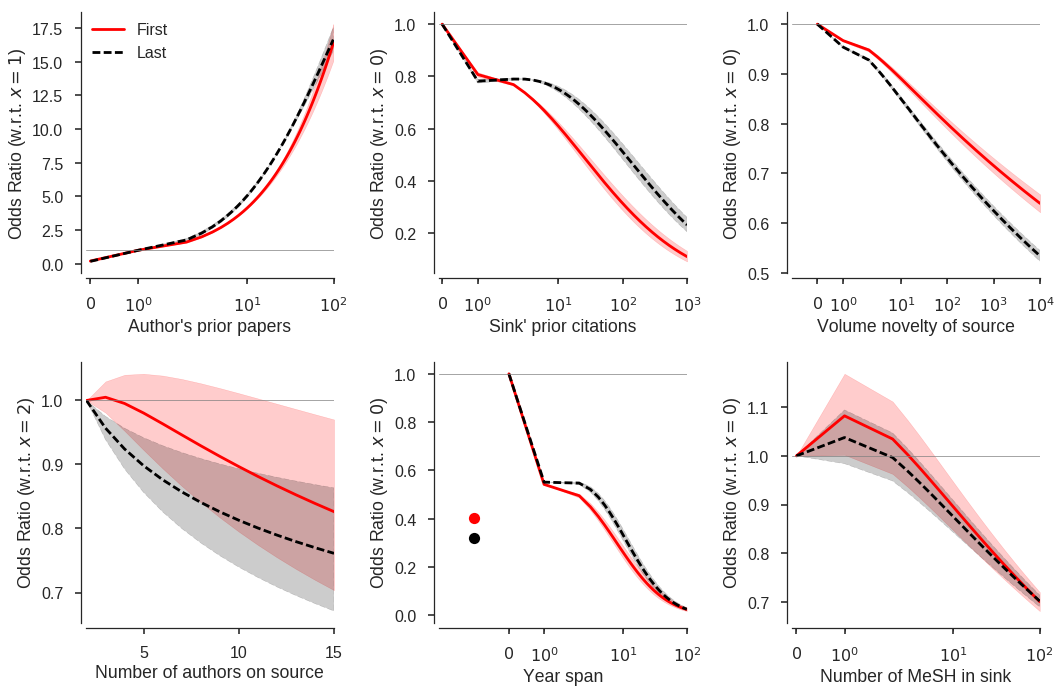

In [29]:
xcols = ["AuthorAge", "SinkCites", "VolumeNovelty",
         "SourceAuthors", "YearSpan", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "Author's prior papers"),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "Number of authors on source"),
    "SinkCites": ("sink_prev_ncites", np.arange(0,1001), "symlog", [-0.1, 1001], None, "Sink' prior citations"),
    "YearSpan": ("year_span", np.arange(-1,101), "symlog", [-2,101], None, "Year span"),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "Volume novelty of source"),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in sink")
}

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
colors = ["r", "k"]
labels = ["First", "Last"]
linestyles = ["-", "--"]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
baseline_index = 0
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, res in enumerate((results_full_fa_f, results_full_la_f)):
        #print labels[j]
        create_model_plot(ax[i], res[-1][0][1][1], feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=1., linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.12,0.95), ncol=1, #title="Author Position",
                fancybox=True, frameon=False)

plt.savefig("Opportunity_Visibility_coeffs.%s.first_last.filtered_%s.OR_%s.pdf" % (MODEL_VERSION, return_odds_ratio, version), 
            bbox_inches="tight", bbox_extra_artists=[lgd])

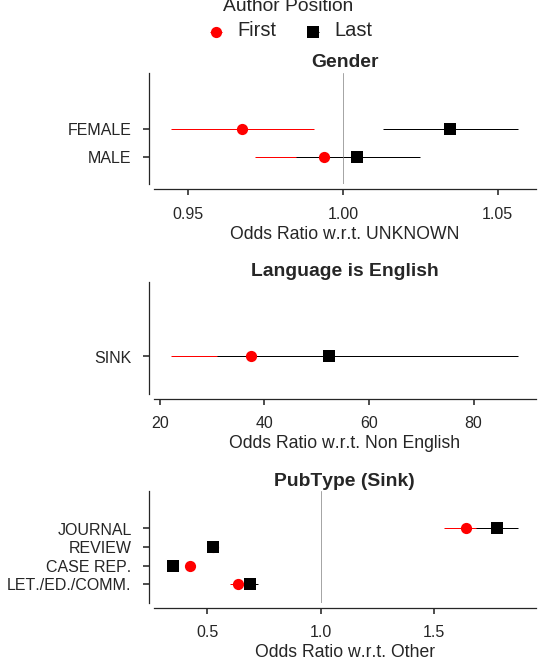

In [30]:
fig = plt.figure(figsize=(8,9))
plot_odds = True
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
colors = ["r", "k"]
labels = ["First", "Last"]
markers = ["o", "s"]


results = (results_full_fa_f, results_full_la_f)
"""
feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((3,1), (0,1), rowspan=3)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)
"""
feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((3,1), (0,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""

feature="Language"
feature_cats = ["Non English", "SINK"]
ax = plt.subplot2grid((3,1), (1,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="sink_"
ax = plt.subplot2grid((3,1), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Sink"), fontweight="bold")


sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.05), ncol=2, title="Author Position",
                fancybox=True, frameon=False, prop={"size": 12})

plt.setp(lgd.get_texts(), fontsize=20)

plt.savefig("Culture_PubType_coeffs.%s.first_last.filtered_%s.OR_%s.pdf" % (MODEL_VERSION, plot_odds, version),
           bbox_inches="tight", bbox_extra_artists=[lgd])

## Comparison between full and individual models

In [31]:
fa_indiv_models = dict(results_full_fa[1])
la_indiv_models = dict(results_full_la[1])


version = 1
results_full_fa_f1 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_FA, version))
results_full_la_f1 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_LA, version))

version = 2
results_full_fa_f2 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_FA, version))
results_full_la_f2 = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX_LA, version))

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.first_author.filtered_1.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.last_author.filtered_1.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: The file 'results_all_model/v4/results_all_model.v4.first_author.filtered_2.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The file 'results_all_model/v4/result

### First author

(w.r.t. $x = 1$)
(w.r.t. $x = 0$)
(w.r.t. $x = 1$)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)


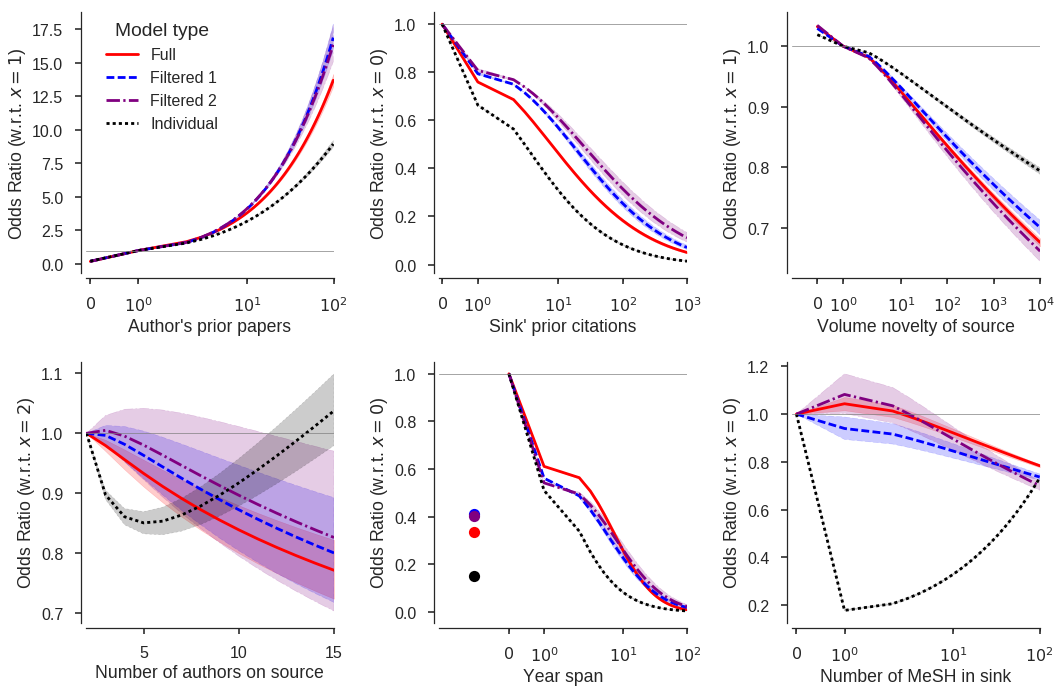

In [32]:
xcols = ["AuthorAge", "SinkCites", "VolumeNovelty",
         "SourceAuthors", "YearSpan", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "Author's prior papers"),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "Number of authors on source"),
    "SinkCites": ("sink_prev_ncites", np.arange(0,1001), "symlog", [-0.1, 1001], None, "Sink' prior citations"),
    "YearSpan": ("year_span", np.arange(-1,101), "symlog", [-2,101], None, "Year span"),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "Volume novelty of source"),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in sink")
}

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
colors = ["r", "b", "purple","k"]
labels = ["Full", "Filtered 1", "Filtered 2","Individual"]
linestyles = ["-", "--", "-.", ":"]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
baseline_index = 0

results = (results_full_fa, results_full_fa_f1, results_full_fa_f2, None)
indiv_models=fa_indiv_models
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge", "VolumeNovelty"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, res in enumerate(results):
        #print labels[j]
        if res is None:
            res = indiv_models[feature][1]
        else:
            res = res[-1][0][1][1]
        create_model_plot(ax[i], res, feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=1., linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.15,0.95), ncol=1, title="Model type",
                fancybox=True, frameon=False)

plt.savefig("Opportunity_Visibility_coeffs.%s.first_indiv.OR_%s.pdf" % (MODEL_VERSION, return_odds_ratio), 
            bbox_inches="tight", bbox_extra_artists=[lgd])

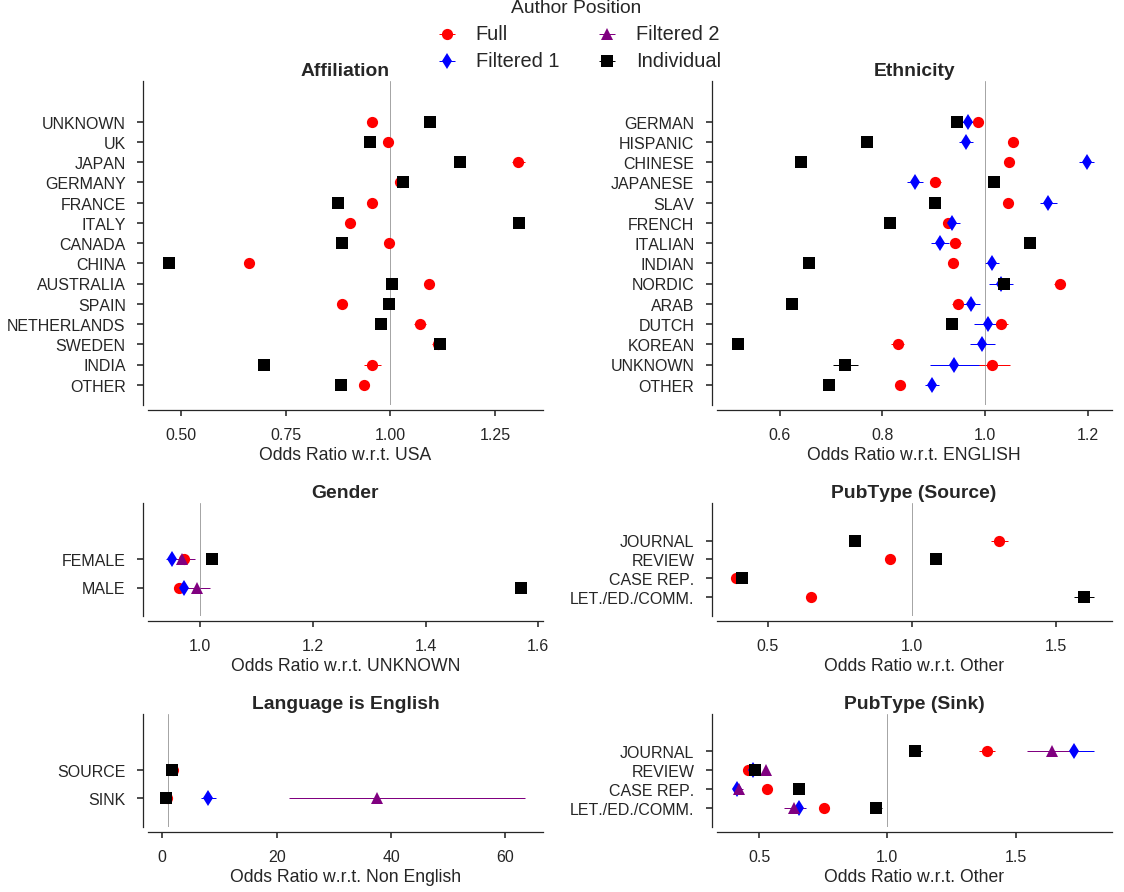

In [33]:
fig = plt.figure(figsize=(16,12))
plot_odds = True
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
colors = ["r", "b", "purple","k"]
labels = ["Full", "Filtered 1", "Filtered 2","Individual"]
markers = ["o", "d", "^","s"]



results = (results_full_fa, results_full_fa_f1, results_full_fa_f2, None)
indiv_models=fa_indiv_models
feature="Affiliation"
feature_cats = TOP_15_COUNTRIES
ax = plt.subplot2grid((4,2), (0,0), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((4,2), (0,1), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((4,2), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Language"
feature_cats = ["Non English", "SOURCE", "SINK"]
ax = plt.subplot2grid((4,2), (3,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="source_"
ax = plt.subplot2grid((4,2), (2,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                             indiv_models=indiv_models, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Source"), fontweight="bold")

filter_string="sink_"
ax = plt.subplot2grid((4,2), (3,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                             indiv_models=indiv_models, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Sink"), fontweight="bold")

sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.05), ncol=2, title="Author Position",
                fancybox=True, frameon=False
                 #, prop={"size": 12}
                )

plt.setp(lgd.get_texts(), fontsize=20)

plt.savefig("Culture_PubType_coeffs.%s.first_indiv.OR_%s.pdf" % (MODEL_VERSION, plot_odds),
           bbox_inches="tight", bbox_extra_artists=[lgd])

### Last author

(w.r.t. $x = 1$)
(w.r.t. $x = 0$)
(w.r.t. $x = 1$)
(w.r.t. $x = 2$)
(w.r.t. $x = 0$)
(w.r.t. $x = 0$)


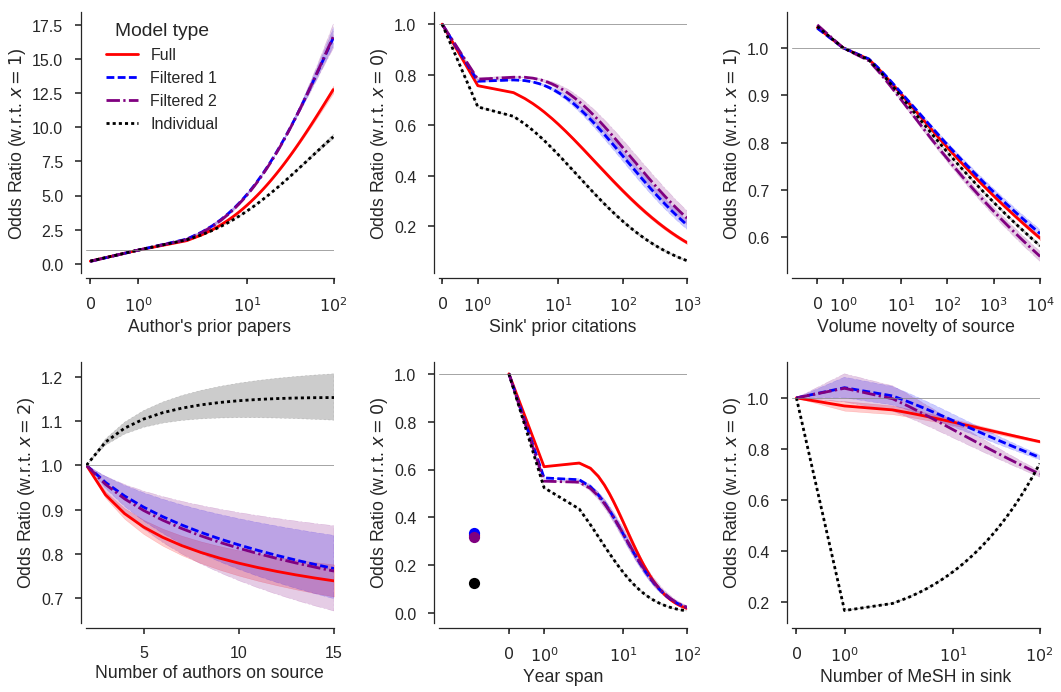

In [34]:
xcols = ["AuthorAge", "SinkCites", "VolumeNovelty",
         "SourceAuthors", "YearSpan", "MeshCounts"]
plot_params_dict = {
    "AuthorAge": ("auth_prev_papers", np.arange(0,100), "symlog", [-0.1, 101], None, "Author's prior papers"),
    "SourceAuthors": ("source_n_authors", np.arange(2,16), "linear", [1.95,15], None, "Number of authors on source"),
    "SinkCites": ("sink_prev_ncites", np.arange(0,1001), "symlog", [-0.1, 1001], None, "Sink' prior citations"),
    "YearSpan": ("year_span", np.arange(-1,101), "symlog", [-2,101], None, "Year span"),
    "VolumeNovelty": ("source_V_novelty", np.arange(0,10001), "symlog", [-1,10001], None, "Volume novelty of source"),
    "MeshCounts": ("sink_n_mesh_ex", np.arange(0,101), "symlog", [-0.1, 101], None, "Number of MeSH in sink")
}

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
colors = ["r", "b", "purple","k"]
labels = ["Full", "Filtered 1", "Filtered 2","Individual"]
linestyles = ["-", "--", "-.", ":"]
ylbl = "Odds Ratio %s"
ylbl_extra = " * Constant"
return_odds_ratio = True
baseline_index = 0

results = (results_full_la, results_full_la_f1, results_full_la_f2, None)
indiv_models=la_indiv_models
for i, feature in enumerate(xcols):
    #print feature
    x_col, x_range, xscale, xlims, ylims, xlbl = plot_params_dict[feature]
    if feature in ["YearSpan", "AuthorAge", "VolumeNovelty"]:
        baseline_index = 1
    else:
        baseline_index = 0
    if return_odds_ratio:
        ylbl_extra = "(w.r.t. $x = %s$)" % x_range[baseline_index]
        print ylbl_extra
    else:
        ylbl_extra = " * Constant"
    for j, res in enumerate(results):
        #print labels[j]
        if res is None:
            res = indiv_models[feature][1]
        else:
            res = res[-1][0][1][1]
        create_model_plot(ax[i], res, feature, feature_dict,
                      x_col, x_range, label=labels[j], color=colors[j], plot_odds=True,
                          linestyle=linestyles[j], filter_string=x_col,
                         baseline_index=baseline_index, return_odds_ratio=return_odds_ratio)
    ax[i].axhline(y=1., linestyle="-", color="0.5", alpha=0.7, lw=1)
    ax[i].set_xlabel(xlbl)
    ax[i].set_xscale(xscale)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].set_ylabel(ylbl % ylbl_extra)
    
sns.despine(offset=5)
fig.tight_layout()
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.15,0.95), ncol=1, title="Model type",
                fancybox=True, frameon=False)

plt.savefig("Opportunity_Visibility_coeffs.%s.last_indiv.OR_%s.pdf" % (MODEL_VERSION, return_odds_ratio), 
            bbox_inches="tight", bbox_extra_artists=[lgd])

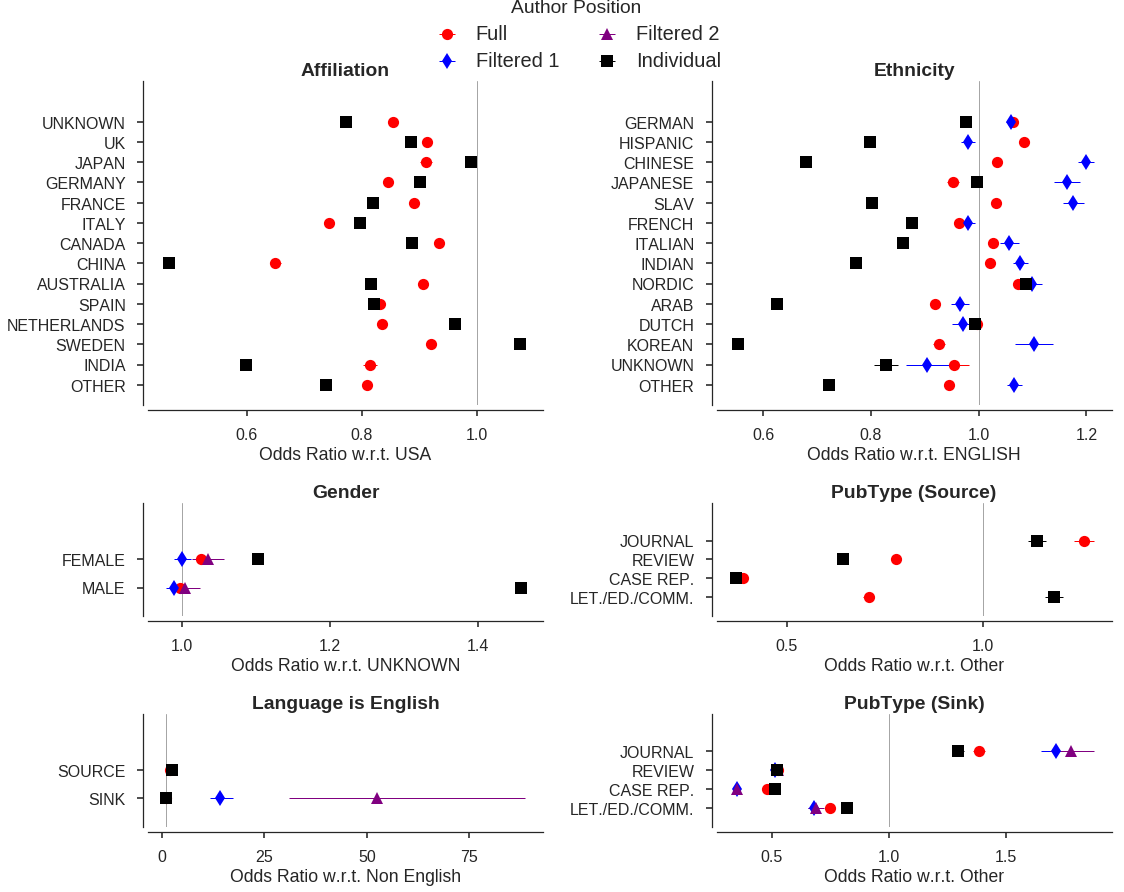

In [35]:
fig = plt.figure(figsize=(16,12))
plot_odds = True
reverse = True
offset=0
xlbl = "Odds Ratio w.r.t. %s"
colors = ["r", "b", "purple","k"]
labels = ["Full", "Filtered 1", "Filtered 2","Individual"]
markers = ["o", "d", "^","s"]



results = (results_full_la, results_full_la_f1, results_full_la_f2, None)
indiv_models=la_indiv_models
feature="Affiliation"
feature_cats = TOP_15_COUNTRIES
ax = plt.subplot2grid((4,2), (0,0), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Ethnicity"
feature_cats = TOP_15_ETHNICITIES
ax = plt.subplot2grid((4,2), (0,1), rowspan=2)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Gender"
feature_cats = GENDERS
ax = plt.subplot2grid((4,2), (2,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)

feature="Language"
feature_cats = ["Non English", "SOURCE", "SINK"]
ax = plt.subplot2grid((4,2), (3,0), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers, indiv_models=indiv_models)
ax.set_title("%s is %s" % (feature, "English"), fontweight="bold")

"""
feature_cats = ["Other"] + ["%s=%s" % (k1,k2)
                            for k1 in ("Source", "Sink")
                            for k2 in ("Journal Article", "Review", "Case Report", "Let. Ed. Comments")]
"""


feature="PubType"
feature_cats=["Other", "JOURNAL", "REVIEW", "CASE REP.", "LET./ED./COMM."]
filter_string="source_"
ax = plt.subplot2grid((4,2), (2,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                             indiv_models=indiv_models, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Source"), fontweight="bold")

filter_string="sink_"
ax = plt.subplot2grid((4,2), (3,1), rowspan=1)
plot_categoricals_from_model(ax, feature, feature_cats, 
                                 results, plot_odds=plot_odds,
                                reverse=reverse, offset=offset, xlbl=xlbl,
                            color=colors, label=labels, marker=markers,
                             indiv_models=indiv_models, filter_string=filter_string)
ax.set_title("%s (%s)" % (feature, "Sink"), fontweight="bold")

sns.despine(offset=5)
fig.tight_layout()

lgd = fig.legend(*ax.get_legend_handles_labels(),
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.05), ncol=2, title="Author Position",
                fancybox=True, frameon=False
                 #, prop={"size": 12}
                )

plt.setp(lgd.get_texts(), fontsize=20)

plt.savefig("Culture_PubType_coeffs.%s.last_indiv.OR_%s.pdf" % (MODEL_VERSION, plot_odds),
           bbox_inches="tight", bbox_extra_artists=[lgd])